# Implementing Softmax Regression by using the Batch Gradient Descent with Early Stoppping, on the Iris dataset

## Objective:

* analyzing the relationship between the types of Iris and its petal length & width.
* predicting the type of Iris based on its petal length and width.
* realizing shorter run time by using early stopping.

## Part 1: Data Preparation


In [152]:
# loading modules
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

# loading data
iris = datasets.load_iris()
list(iris.keys())
X = iris["data"][:, (2,3)] #petal length & width
y = iris["target"].astype(np.int)

# adding bias term
X = np.c_[np.ones([len(X),1]), X]

# splitting training and test datasets
def split_train_test(X, y, test_ratio, val_ratio):
    test_size = int(len(X) * test_ratio)
    val_size = int(len(X) * val_ratio)
    train_size = len(X) - test_size - val_size
    indices = np.random.permutation(len(X))
    X_train = X[indices[:train_size]]
    y_train = y[indices[:train_size]]
    X_valid = X[indices[train_size:-test_size]]
    y_valid = y[indices[train_size:-test_size]]
    X_test = X[indices[-test_size:]]
    y_test = y[indices[-test_size:]]
    return X_train, y_train, X_valid, y_valid, X_test, y_test
X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test(X,y,0.2,0.2)

C:\Users\antho\AppData\Local\Temp\ipykernel_11252\900554092.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = iris["target"].astype(np.int)


Since the target has 3 classes, we need to encode them into a matrix containing a one-hot vector for each class, in order to train the Softmax Regression model.

In [153]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [154]:
# demonstrating
y_train[:10]

array([2, 0, 0, 1, 0, 0, 2, 1, 1, 0])

In [155]:
to_one_hot(y_train[:10])

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

## Part 2: Fitting the model

Recall that the predicted probability by Softmax regression is calculated as follows:

$$\sigma(s(x))_k = \frac{\exp(s_k(x))}{\sum_{j=1}^K \exp(s_j(x))}$$

In [156]:
# implementing softmax prediction funciton
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

The cost function of Softmax regression is:

$$
J(\Theta)=-\frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K y_k^{(i)}\log(\hat p_k^{(i)})
$$

and its gradient is:

$$
\nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m} \sum_{i=1}^m \Big( \hat p _k^{(i)} - y_k ^{(i)}\Big)x^{(i)}
$$

In [157]:
# implementing the Batch Gradient Descent Algorithm
def batch_gradient_descent(X_train, y_train, eta, n_iterations, epsilon):
    n_inputs = X_train.shape[1]
    n_outputs = len(np.unique(y_train))
    Theta = np.random.randn(n_inputs, n_outputs)
    y_train_one_hot = to_one_hot(y_train)
    y_valid_one_hot = to_one_hot(y_valid)
    y_test_one_hot = to_one_hot(y_test)
    for iteration in range(n_iterations):
        logits = X_train.dot(Theta)
        y_proba = softmax(logits)
        if iteration % 500 == 0:
            loss = -np.mean(np.sum(y_train_one_hot * np.log(y_proba + epsilon), axis=1))
        error = y_proba - y_train_one_hot
        gradients = 1/len(X_train) * X_train.T.dot(error)
        Theta = Theta - eta * gradients
    return Theta

Theta = batch_gradient_descent(X_train, y_train, 0.01, 5000, 1e-7)

In [158]:
# fitted model:
Theta

array([[ 3.32869753, -0.34527866, -4.54519084],
       [-2.02548527, -0.77769323,  0.09708478],
       [-0.61370951,  0.2207068 ,  0.3770351 ]])

In [159]:
# validating
def val_accuracy(X_valid, y_valid, Theta):
    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    y_predict = np.argmax(Y_proba, axis=1)
    accuracy_score = np.mean(y_predict == y_valid)
    return accuracy_score

val_accuracy(X_valid, y_valid, Theta)

0.8333333333333334

#### Remark: accuracy will change for each run, because the randomization seed is not fixed.

So, let's see an overall accuracy over 100 runs:

(array([ 1.,  1.,  1.,  7.,  7., 19., 26., 42., 37., 58.]),
 array([0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 10 artists>)

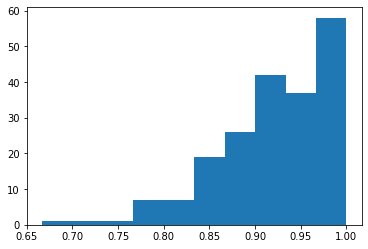

In [160]:
results = []
for counter in range(1, 200):
    X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test(X,y,0.2,0.2)
    Theta = batch_gradient_descent(X_train, y_train, 0.01, 5000, 1e-7)
    temp = val_accuracy(X_valid, y_valid, Theta)
    results.append(temp)

plt.hist(results)

We see this model is doing pretty well! But we can do better!

Let's add the $\ell_2$ regularization:

In [161]:
# implementing batch GD algorithm with l2 regularization
def batch_gradient_descent_l2regularized(X_train, y_train, eta, n_iterations, epsilon, alpha): # alpha is regularization hyperparameter
    n_inputs = X_train.shape[1]
    n_outputs = len(np.unique(y_train))
    y_train_one_hot = to_one_hot(y_train)
    y_valid_one_hot = to_one_hot(y_valid)
    y_test_one_hot = to_one_hot(y_test)
    Theta = np.random.randn(n_inputs, n_outputs)
    for iteration in range(n_iterations):
        logits = X_train.dot(Theta)
        Y_proba = softmax(logits)
        if iteration % 500 == 0:
            xentropy_loss = -np.mean(np.sum(y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
            l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
            loss = xentropy_loss + alpha * l2_loss
        error = Y_proba - y_train_one_hot
        gradients = 1/len(X_train) * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
        Theta = Theta - eta * gradients
    return Theta

Theta = batch_gradient_descent_l2regularized(X_train, y_train, 0.1, 5000, 1e-7, 0.1)
Theta

array([[ 4.91174419,  1.14605674, -3.89234417],
       [-1.07556068,  0.13235907,  0.94320162],
       [-0.45328978, -0.14820346,  0.60149324]])

In [162]:
val_accuracy(X_valid, y_valid, Theta)

0.9666666666666667

(array([ 1.,  2.,  2.,  8., 10., 12., 38., 17., 46., 63.]),
 array([0.56666667, 0.61      , 0.65333333, 0.69666667, 0.74      ,
        0.78333333, 0.82666667, 0.87      , 0.91333333, 0.95666667,
        1.        ]),
 <BarContainer object of 10 artists>)

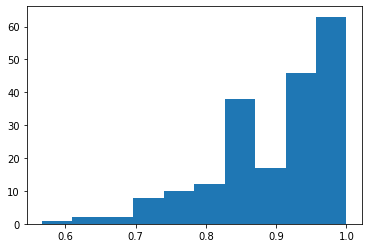

In [163]:
results = []
for counter in range(1, 200):
    X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test(X,y,0.2,0.2)
    y_train_one_hot = to_one_hot(y_train)
    y_valid_one_hot = to_one_hot(y_valid)
    Theta = batch_gradient_descent_l2regularized(X_train, y_train, 0.01, 5000, 1e-7, 0.1)
    temp = val_accuracy(X_valid, y_valid, Theta)
    results.append(temp)

plt.hist(results)


Now, let's add early stoppping:

In [164]:
# implementing the early stopping
def batch_gradient_descent_l2regularized_earlystopping(X_train, y_train, eta, n_iterations, epsilon, alpha):
    n_inputs = X_train.shape[1]
    n_outputs = len(np.unique(y_train))
    y_train_one_hot = to_one_hot(y_train)
    y_valid_one_hot = to_one_hot(y_valid)
    y_test_one_hot = to_one_hot(y_test)
    best_loss = np.infty
    Theta = np.random.randn(n_inputs, n_outputs)
    for iteration in range(n_iterations):
        logits = X_train.dot(Theta)
        Y_proba = softmax(logits)
        error = Y_proba - y_train_one_hot
        gradients = 1/len(X_train) * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
        Theta = Theta - eta * gradients
        logits = X_valid.dot(Theta)
        Y_proba = softmax(logits)
        xentropy_loss = -np.mean(np.sum(y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        if loss < best_loss:
            best_loss = loss
        else:
            break
    return Theta

Theta = batch_gradient_descent_l2regularized_earlystopping(X_train, y_train, 0.01, 5000, 1e-7, 0.1)
Theta

array([[ 3.65060297,  0.32876716, -1.9857755 ],
       [-0.78361508,  0.23404325,  0.56287164],
       [-0.40635665, -0.12996651,  0.54905098]])

(array([  3.,   0.,   0.,   6.,   0.,   6.,  10.,  16.,  54., 104.]),
 array([0.13333333, 0.22      , 0.30666667, 0.39333333, 0.48      ,
        0.56666667, 0.65333333, 0.74      , 0.82666667, 0.91333333,
        1.        ]),
 <BarContainer object of 10 artists>)

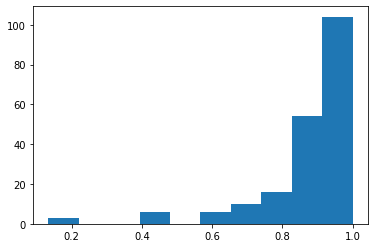

In [165]:
results = []
for counter in range(1, 200):
    X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test(X,y,0.2,0.2)
    y_train_one_hot = to_one_hot(y_train)
    y_valid_one_hot = to_one_hot(y_valid)
    Theta = batch_gradient_descent_l2regularized_earlystopping(X_train, y_train, 0.01, 5000, 1e-7, 0.1)
    temp = val_accuracy(X_valid, y_valid, Theta)
    results.append(temp)

plt.hist(results)

## Part 3: Prediction

In [151]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333